In [1]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
import json

def load_json(file_path):
    with open(file_path) as f:
        return json.load(f)

In [3]:
data = load_json("hw2_data/clip_zeroshot/id2label.json")

In [4]:
import os 
from tqdm import tqdm
from torchvision import io, transforms as T

def run_clip(model):
    model, transform = clip.load(model, device=device)
    out = {
        'failure': [],
        'success': []
    }

    class_labels = ["a photo of {}.".format(v) for v in data.values()]

    with torch.no_grad():
        text_inputs = clip.tokenize(class_labels).to(device)
    
    correct = 0
    total = 0
    root_dir = 'hw2_data/clip_zeroshot/val/'
    for image_path in tqdm(os.listdir(root_dir)):
        label = int(image_path.split('_')[0])

        image_path = os.path.join(root_dir, image_path)
        image = Image.open(image_path)
        
        image_input = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_inputs)

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            similarity = (image_features @ text_features.T).squeeze(0)
            best_match = similarity.argmax().item()

        if label == best_match:
            correct += 1
            out['success'].append({
                'image': image,
                'pred': best_match,
                'real': label
            })
        else:
            out['failure'].append({
                'image': image,
                'pred': best_match,
                'real': label
            })

        total += 1

    print(f"accuracy: {correct / total : .4f}")
    return out

In [5]:
result = run_clip("ViT-B/32")

100%|██████████| 2500/2500 [01:07<00:00, 36.89it/s] 

accuracy:  0.5648


In [6]:
import random
import matplotlib.pyplot as plt

def show_result(result, key, num_result):
    target = result[key]
    fig, axes = plt.subplots(1, num_result, figsize=(15, 3))  # 1x5 格式

    target_data = []
    for _ in range(num_result):
        idx = random.randint(0, len(target)-1)
        target_data.append(target[idx])

    # 繪圖
    for i, item in enumerate(target_data):
        axes[i].imshow(item['image'])  # 顯示圖像
        axes[i].axis('off')  # 隱藏座標軸
        # 顯示預測和實際標籤
        axes[i].set_title(f"Pred: {data[str(item['pred'])]}\nReal: {data[str(item['real'])]}")

    plt.tight_layout()

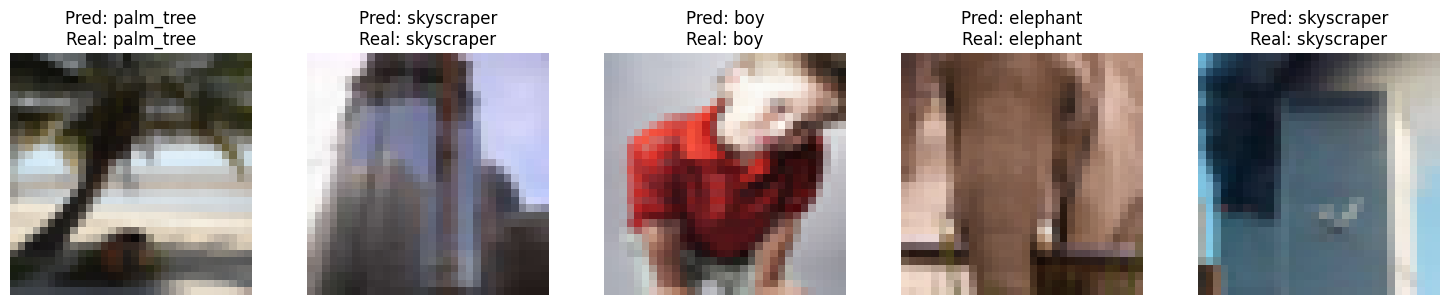

In [7]:
show_result(result, 'success', 5)

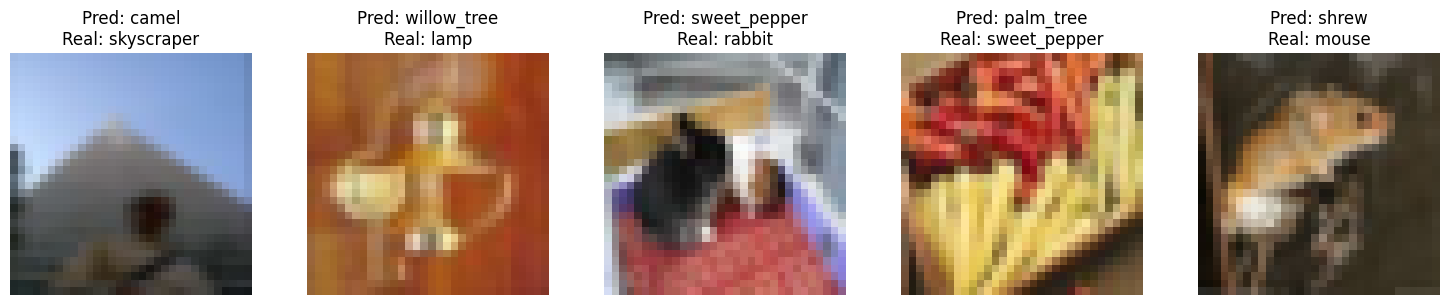

In [8]:
show_result(result, 'failure', 5)

In [9]:
result = run_clip("ViT-L/14")

100%|██████████| 2500/2500 [01:53<00:00, 22.05it/s] 

accuracy:  0.7692


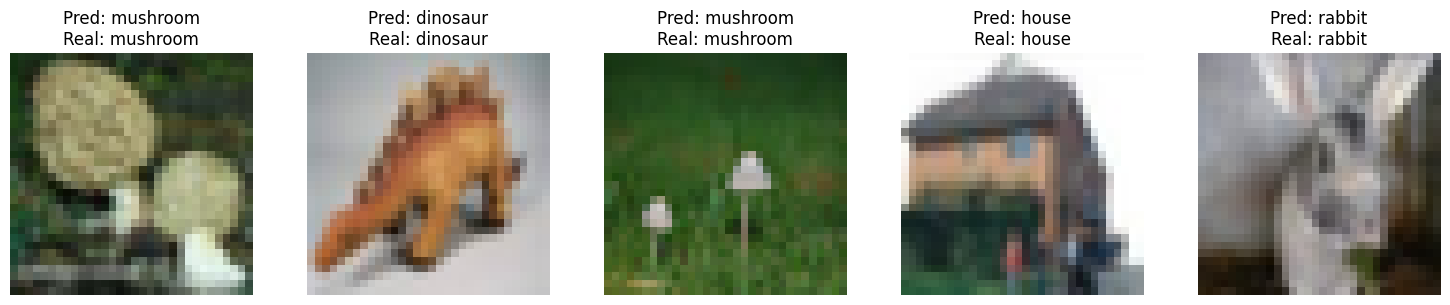

In [10]:
show_result(result, 'success', 5)

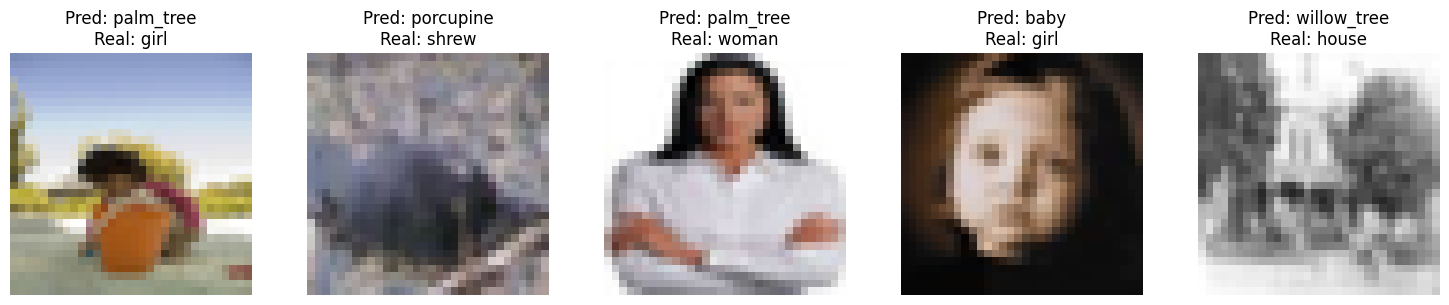

In [11]:
show_result(result, 'failure', 5)